Homework 4: Population Modelling

In [271]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [272]:
import torch
import torch.nn as nn
import torch.optim as optim

1. Data Preprocessing

In [273]:
# this function is a moving average function that smooths out the discrete data from the simulation
def moving_average(data, window_size=250):
    temp = data
    for i in range(len(data)):
        temp[i] = np.convolve(data[i], np.ones(window_size)/window_size, 'same')
    return temp

In [274]:
# this loads up the original raw dataset

def load_data(file_path):
    with open(file_path, 'rb') as filename:
        raw_dataset = pickle.load(filename)
        for i in range(len(raw_dataset)):
            raw_dataset[i] = raw_dataset[i].tolist()
    raw_dataset = np.transpose(np.array(raw_dataset[:5000]))

    # this code below loads up the dataset and then smooths it out using the moving average function

    with open(file_path, 'rb') as filename:
        dataset = pickle.load(filename)
        for i in range(len(dataset)):
            dataset[i] = dataset[i].tolist()

    dataset = np.transpose(np.array(dataset[:5000]))
    smooth_dataset = moving_average(dataset)
    return (raw_dataset,smooth_dataset)

Using the above function, you can load any of the ten datasets built from the simulation experiment, and then run the rest of this notebook to build, train, and use its lotka-volterra model.

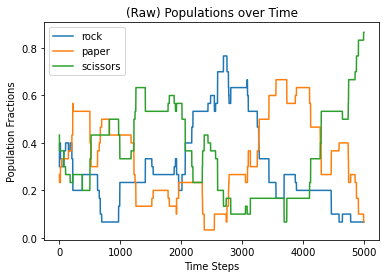

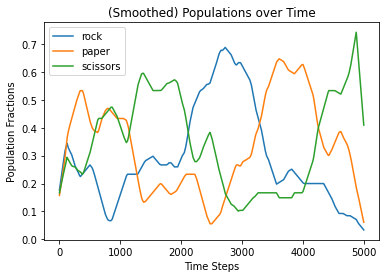

In [275]:
raw_dataset, smooth_dataset=load_data('datasets/dataset_01.pkl')

# plot for raw data
plt.figure()
plt.xlabel("Time Steps")
plt.ylabel("Population Fractions")
plt.title("(Raw) Populations over Time")
plt.plot(list(range(5000)), raw_dataset[0])
plt.plot(list(range(5000)), raw_dataset[1])
plt.plot(list(range(5000)), raw_dataset[2])
plt.legend(["rock", "paper", "scissors"])
plt.show()

# plot for smoothed data
plt.figure()
plt.xlabel("Time Steps")
plt.ylabel("Population Fractions")
plt.title("(Smoothed) Populations over Time")
plt.plot(list(range(5000)), smooth_dataset[0])
plt.plot(list(range(5000)), smooth_dataset[1])
plt.plot(list(range(5000)), smooth_dataset[2])
plt.legend(["rock", "paper", "scissors"])
plt.show()

In the Lokta Volterra Model, the terms of form c*u where c is a constant and u is a variable representing one of the three agents (rock, paper, scissors), don't make sense in our simulation because the agent don't naturally die or are born. The only way population changes is through the other term c*u*v. Since our model will have three agents instead of two, the dynamical system will have three equations, with each equation having two terms, c*u*v and c*u*w, where u is the given agent, and w and v are the other two agent predator/prey

2. Model Fitting

The dynamical system model involves derivatives of each agents population, so we have to calculate these derivatives using differences and the slope formula, so that they can be used as training data for fitting the dynamical system model. In this code block, we also preprocess the time tensor that keeps track of timesteps, and the training dataset of rock,paper,scissors populations

In [276]:
t = torch.linspace(0, 5000, 5000)

train_X = torch.Tensor(smooth_dataset)

dt = t[1] - t[0]
dxdt_torch = torch.diff(train_X,axis=1)/dt

train_Y = dxdt_torch
train_X = train_X[:,:-1]

t = t[:-1]

print(train_X.size())
print(train_Y.size())
print(t.size())

torch.Size([3, 4999])
torch.Size([3, 4999])
torch.Size([4999])


Now we have all the data needed for all variables in our dynamical system, so we can build the model by calculating parameters using PyTorch.

In [277]:
class PopulationFitModel(nn.Module):
    def __init__(self):
        super(PopulationFitModel, self).__init__()
        # Define whatever model parameters you want to add.
        # Don't forget to set 'requires_grad=True' for trainable parameters
        self.coeffs = nn.parameter.Parameter(torch.zeros(3,2, requires_grad=True, dtype=torch.double))
        
        self.alpha = self.coeffs[0,0]
        self.beta = self.coeffs[0,1]
        self.gamma = self.coeffs[1,0]
        self.delta = self.coeffs[1,1]
        self.epsilon = self.coeffs[2,0]
        self.zeta = self.coeffs[2,1]
    
    def forward(self, x):
        # Put code here that will evaluate the model
        
        x = train_X.index_select(0,torch.tensor(0))
        y = train_X.index_select(0,torch.tensor(1))
        z = train_X.index_select(0,torch.tensor(2))

        # lotka-volterra model dynamical system set up in pytorch

        dx_dt = self.alpha * x * y + self.beta * x * z
        dy_dt = self.gamma * x * y + self.delta * y * z
        dz_dt = self.epsilon * z * x + self.zeta * z * y
        
        return torch.cat([dx_dt,dy_dt,dz_dt], 0)

Next, we train the model using Adam gradient descent that finds the parameters of the dynamical system that result in a minimum loss.

In [278]:
model = PopulationFitModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model.coeffs)

num_epochs = 10000
for epoch in range(num_epochs):
    # First, we recompute the loss, and take derivatives
    optimizer.zero_grad()
    outputs = model(train_X)
    loss = torch.mean((outputs-train_Y)**2)
    loss.backward()
    # Use the optimizer to tune the weights in the model
    optimizer.step()

    # Print out the loss so you can track whether things are getting better
    if epoch % 100 == 0:
        print('Epoch {}, Loss {}'.format(epoch, loss.item()))

print(model.coeffs)

Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64, requires_grad=True)
Epoch 0, Loss 4.311102088649932e-07
Epoch 100, Loss 3.820172480573092e-07
Epoch 200, Loss 3.8201676488824887e-07
Epoch 300, Loss 3.820167933099583e-07
Epoch 400, Loss 3.8201676488824887e-07
Epoch 500, Loss 3.820892402472964e-07
Epoch 600, Loss 3.8201676488824887e-07
Epoch 700, Loss 3.8203359054023167e-07
Epoch 800, Loss 3.8201673646653944e-07
Epoch 900, Loss 3.8211899777707004e-07
Epoch 1000, Loss 3.820172764790186e-07
Epoch 1100, Loss 3.8201676488824887e-07
Epoch 1200, Loss 3.8201898178158444e-07
Epoch 1300, Loss 3.8201673646653944e-07
Epoch 1400, Loss 3.8201676488824887e-07
Epoch 1500, Loss 3.820836127488292e-07
Epoch 1600, Loss 3.8201673646653944e-07
Epoch 1700, Loss 3.8205499208743277e-07
Epoch 1800, Loss 3.820511835783691e-07
Epoch 1900, Loss 3.8201673646653944e-07
Epoch 2000, Loss 3.823899703547795e-07
Epoch 2100, Loss 3.820831864231877e-07
Epoch 2200, Loss 3.8201

I implemented euler's method, and then created a helper function that could work with the full three populations, to find the solution to the derivatives calculated from the model 

In [279]:
# euler's method implemented to find the solution from the derivative

def euler(initial, derivatives):
    i = initial.item()
    integrated = [i]
    for dx_dt in derivatives:
        i += (dx_dt.item())
        integrated.append(i)
    return integrated

def total_population(initials, derivatives):
    x=euler(initials[0], derivatives[0])
    y=euler(initials[1], derivatives[1])
    z=euler(initials[2], derivatives[2])
    return [x,y,z]

Example of solution using the original dataset loaded

tensor([0.1761, 0.1573, 0.1665])
[[0.17613333333333334, 0.17612841719432812, 0.17612325749991772, 0.17611785066305505, 0.1761121931112449, 0.17610628125744018, 0.17610011152186975, 0.1760936803320384, 0.17608698409362308, 0.17608001924140457, 0.17607278217378383, 0.1760652693328176, 0.1760574771096309, 0.17604940195355642, 0.17604104025571918, 0.1760323884581759, 0.17602344296660352, 0.1760142002012309, 0.17600465657501094, 0.17599480851544844, 0.17598465245732417, 0.17597418479176316, 0.17596340195354618, 0.17595230034835016, 0.17594087641823183, 0.17592905129908662, 0.17591682060351208, 0.17590417990772597, 0.17589112478794608, 0.17587765085676996, 0.17586375369041538, 0.17584942887237606, 0.17583467200069766, 0.1758194786588739, 0.17580384442312255, 0.17578776489148926, 0.17577123566929562, 0.17575425231093153, 0.17573681041444264, 0.1757189055778746, 0.17570053339199707, 0.17568168941847592, 0.17566236927718468, 0.17564256852978918, 0.17562228278161104, 0.17560150762341994, 0.17558

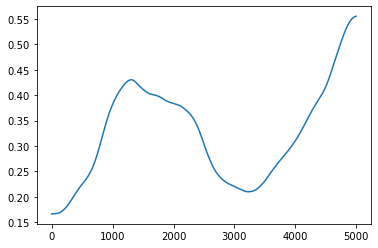

In [280]:
print(train_X[:,0])

dx_dt_fit=model(train_X)

populations = total_population(abs(smooth_dataset[:,0]),dx_dt_fit)

print(populations)

t_new = np.linspace(0, 5000, 5000)

plt.plot(t_new, populations[2])

Graphing the solutions for the dataset loaded

In [281]:
def plot_populations(populations, smooth_dataset):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

    ax1.set_title("Rock population over time, actual vs predicted")
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Population Portion")
    ax1.plot(t_new, populations[0], '--', color="red")
    ax1.plot(t_new, smooth_dataset[0], color="red")
    ax1.legend(["Predicted", "Actual"])

    ax2.set_title("Paper population over time, actual vs predicted")
    ax2.set_xlabel("Time Step")
    ax2.set_ylabel("Population Portion")
    ax2.plot(t_new, populations[1], '--', color="blue")
    ax2.plot(t_new, smooth_dataset[1], color="blue")
    ax2.legend(["Predicted", "Actual"])

    ax3.set_title("Scissors population over time, actual vs predicted")
    ax3.set_xlabel("Time Step")
    ax3.set_ylabel("Population Portion")
    ax3.plot(t_new, populations[2], '--', color="green")
    ax3.plot(t_new, smooth_dataset[2], color="green")
    ax3.legend(["Predicted", "Actual"])

    plt.show()

    fig1, (ax4, ax5) = plt.subplots(1, 2, figsize=(18, 4))

    ax4.set_title("Predicted Populations compared over time")
    ax4.set_xlabel("Time Step")
    ax4.set_ylabel("Population Portion")
    ax4.plot(t_new, populations[0], '--', color="red")
    ax4.plot(t_new, populations[1], '--', color="blue")
    ax4.plot(t_new, populations[2], '--', color="green")
    ax4.legend(["Rock", "Paper","Scissors"])

    ax5.set_title("Actual Populations compared over time")
    ax5.set_xlabel("Time Step")
    ax5.set_ylabel("Population Portion")
    ax5.plot(t_new, smooth_dataset[0], color="red")
    ax5.plot(t_new, smooth_dataset[1], color="blue")
    ax5.plot(t_new, smooth_dataset[2], color="green")
    ax5.legend(["Rock", "Paper","Scissors"])

    plt.show()

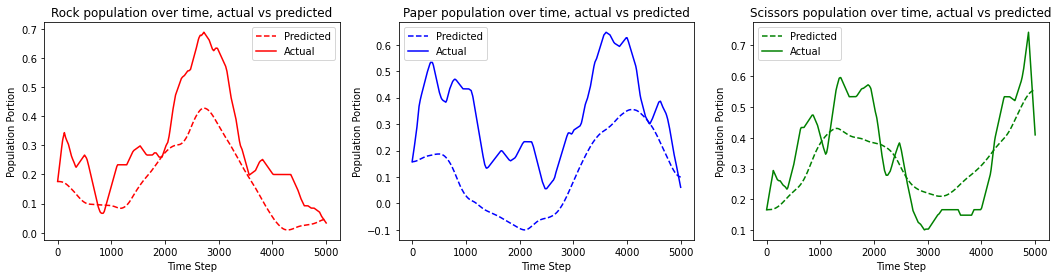

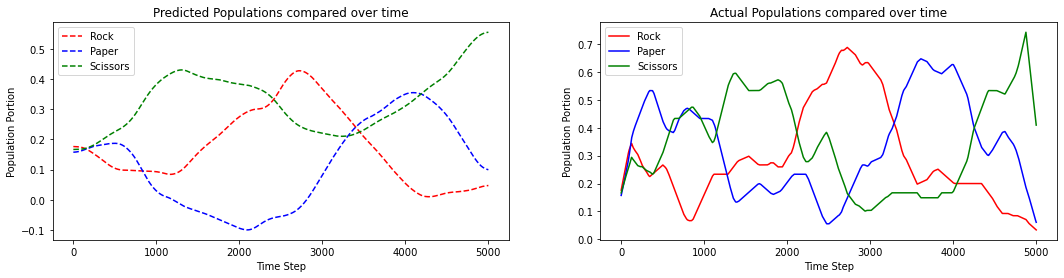

Parameters for this population system's lotka volterra model
Parameter containing:
tensor([[-0.0029,  0.0026],
        [ 0.0032, -0.0027],
        [-0.0019,  0.0023]], dtype=torch.float64, requires_grad=True)


In [282]:
plot_populations(populations, smooth_dataset)

print("Parameters for this population system's lotka volterra model")
print(model.coeffs)

3. Actual Science found in PDF document attached